![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=4+-+Vertex+AI+AutoML+Forecasting+-+Python+client.ipynb)

# 4 - Vertex AI - AutoML for Global Forecasting with Deep Learning - with Python client (code)

A newer way to fit forecast models to time series data is by using a deep learning approach with neural networks. This approah can have added success because it is a global forecast, it not only sees and individual time series but also sees across many time series and can learn together from correlation.  This approach can also include covariate features that may only be known in the past or may also be available at forecast time. Vertex AI AutoML forecasting will do automatic feature engineering, model architecture search and hyperparameter tuning specific to time series data.  This method using a set of data between the training data and the test data called validation data to time series specific approachs using deep learning architectures.  

**In this notebook, the Vertex AI Python Client is used to automate the process of using Vertex AI AutoML Forecasting with interactive code.**  The best part, is all the test data will be forecasted and written back to BigQuery where we will review it, visualize it, and calcualte custom metrics to make fair comparison to other methods explored in this notebook series (`04`).

### Prerequisites:
- 04 - Time Series Forecasting - Data Review in BigQuery

### Resources:
- [Train an AutoML model (Vertex AI API)](https://cloud.google.com/vertex-ai/docs/training/automl-api#forecasting)
- [Vertex AI Forecast: An Overview](https://cloud.google.com/blog/topics/developers-practitioners/vertex-forecast-overview)
- [Optimization objectives for tabular AutoML models](https://cloud.google.com/vertex-ai/docs/training/tabular-opt-obj#forecasting)
- [Evaluation metrics returned by Vertex AI](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models#evaluation_metrics_returned_by)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/afore4_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/afore4_console.png" width="45%">
</p>

---
## Setup

inputs:

In [ ]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

In [48]:
REGION = 'us-central1'
DATANAME = 'citibikes'
NOTEBOOK = '04c'

packages:

In [49]:
from google.cloud import bigquery
from google.cloud import aiplatform

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [50]:
bigquery = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

---
## Create Dataset (Link to BigQuery Table)

Reference for [`aiplatform.TimeSeriesDataset.create`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.TimeSeriesDataset.create)

In [51]:
dataset = aiplatform.TimeSeriesDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TimeSeriesDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TimeSeriesDataset backing LRO: projects/715288179162/locations/us-central1/datasets/189656959698337792/operations/1790227649843429376
INFO:google.cloud.aiplatform.datasets.dataset:TimeSeriesDataset created. Resource name: projects/715288179162/locations/us-central1/datasets/189656959698337792
INFO:google.cloud.aiplatform.datasets.dataset:To use this TimeSeriesDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/189656959698337792')


In [52]:
#dataset = aiplatform.TimeSeriesDataset('projects/715288179162/locations/us-central1/datasets/2757130959764586496')

---
## Train Forecasting Model with AutoML

### Create AutoML Forecasting Job

Reference for [`aiplatform.AutoMLForecastingTrainingJob`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob)

In [53]:
dataset.column_names

['start_station_name', 'num_trips', 'splits', 'date']

In [54]:
column_specs = list(set(dataset.column_names) - set(['splits','start_station_name']))
column_specs = dict.fromkeys(column_specs, 'auto')
column_specs

{'num_trips': 'auto', 'date': 'auto'}

In [57]:
forecast_job = aiplatform.AutoMLForecastingTrainingJob(
    display_name = f'{NOTEBOOK}_{DATANAME}',
    optimization_objective = "minimize-rmse",
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

### Run AutoML Forecasting Job

Reference for [`aiplatform.AutoMLForecastingTrainingJob.run`](https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLForecastingTrainingJob.run)

In [58]:
forecast = forecast_job.run(
    dataset = dataset,
    target_column = "num_trips",
    time_column = "date",
    time_series_identifier_column = "start_station_name",
    unavailable_at_forecast_columns = ["num_trips",],
    available_at_forecast_columns = ["date",],
    forecast_horizon = 14,
    data_granularity_unit = "day",
    data_granularity_count = 1,
    predefined_split_column_name = "splits",
    context_window = 28,
    export_evaluated_data_items = True,
    export_evaluated_data_items_bigquery_destination_uri = f"bq://{PROJECT_ID}:{DATANAME}:{NOTEBOOK}_automl",
    validation_options = "fail-pipeline",
    budget_milli_node_hours = 100,
    model_display_name = f"{NOTEBOOK}_{DATANAME}_{TIMESTAMP}",
    model_labels = {'notebook':f'{NOTEBOOK}'},
    holiday_regions = ['GLOBAL', 'NA', 'US'],
    sync = False
)

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/7482076021701738496?project=715288179162
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/7482076021701738496 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/7482076021701738496 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/7482076021701738496 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLForecastingTrainingJob projects/715288179162/locations/us-central1/trainingPipelines/7482076021701738496 current state:
PipelineState.PIPELINE_STATE_RUNNING
I

# Using The Results
---
## Results

### Retrieve Test Data

In [59]:
query = f"""
WITH
    RAW AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM RAW
    ),
    LEFTSIDE AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD
        GROUP BY start_station_name, date
    )
SELECT *
FROM LEFTSIDE
LEFT OUTER JOIN LEAD
USING (start_station_name, date, prediction_lead_days)
"""
autoML = bigquery.query(query = query).to_dataframe()
autoML

,start_station_name,date,prediction_lead_days,predicted_on_date,num_trips,splits,predicted_num_trips
0,Central Park S & 6 Ave,2016-09-17,0,2016-09-17,607,TEST,431.337463
1,Central Park W & W 96 St,2016-09-17,0,2016-09-17,153,TEST,123.006325
2,Central Park West & W 68 St,2016-09-17,0,2016-09-17,251,TEST,192.351059
3,Central Park West & W 72 St,2016-09-17,0,2016-09-17,264,TEST,258.862610
4,Central Park West & W 76 St,2016-09-17,0,2016-09-17,177,TEST,137.220825
...,...,...,...,...,...,...,...
154,Central Park West & W 100 St,2016-09-30,0,2016-09-30,13,TEST,42.739956
155,Central Park West & W 102 St,2016-09-30,0,2016-09-30,10,TEST,52.558765
156,W 106 St & Central Park West,2016-09-30,0,2016-09-30,32,TEST,61.927174
157,Grand Army Plaza & Central Park S,2016-09-30,0,2016-09-30,43,TEST,236.529984


### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [60]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT start_station_name, time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    AVG(POW(diff, 2)) as MSE,
    SQRT(AVG(POW(diff, 2))) as RMSE,
    SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE
FROM DIFFS
GROUP BY start_station_name, time_series_type
ORDER BY start_station_name, time_series_type    
"""
customMetrics = bigquery.query(query = query).to_dataframe()
customMetrics

,start_station_name,time_series_type,MAPE,MAE,pMAE
0,Central Park North & Adam Clayton Powell Blvd,forecast,0.769584,55.278931,0.356146
1,Central Park S & 6 Ave,forecast,0.529365,85.900534,0.263210
2,Central Park W & W 96 St,forecast,0.611290,25.250980,0.252330
3,Central Park West & W 100 St,forecast,1.029296,16.631971,0.419545
4,Central Park West & W 102 St,forecast,0.549840,12.745935,0.251683
5,Central Park West & W 68 St,forecast,0.474713,44.619728,0.294520
6,Central Park West & W 72 St,forecast,0.649053,51.374403,0.290377
7,Central Park West & W 76 St,forecast,0.354736,25.185355,0.230003
8,Central Park West & W 85 St,forecast,1.169595,53.294625,0.423935
9,Grand Army Plaza & Central Park S,forecast,0.580776,61.298214,0.281881


Overall Metrics:

In [61]:
query = f"""
WITH
    FORECASTS AS (
        SELECT DATE(date) as date, DATE(predicted_on_date) as predicted_on_date, CAST(num_trips as INT64) AS num_trips, splits, start_station_name, predicted_num_trips.value as predicted_num_trips
        FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl`
    ),
    LEAD_DAYS AS (
        SELECT *, DATE_DIFF(date, predicted_on_date, DAY) as prediction_lead_days
        FROM FORECASTS
    ),
    LATEST AS (
        SELECT start_station_name, date, min(prediction_lead_days) as prediction_lead_days
        FROM LEAD_DAYS
        GROUP BY start_station_name, date
    ),
    DIFFS AS (
        SELECT 
            start_station_name, date, 'forecast' as time_series_type,
            predicted_num_trips as forecast_value,
            num_trips as actual_value,
            (num_trips - predicted_num_trips) as diff
        FROM LATEST
        LEFT OUTER JOIN LEAD_DAYS
        USING (start_station_name, date, prediction_lead_days)    
    )
SELECT time_series_type, 
    AVG(ABS(diff)/actual_value) as MAPE,
    AVG(ABS(diff)) as MAE,
    SUM(ABS(diff))/SUM(actual_value) as pMAE,
    AVG(POW(diff, 2)) as MSE,
    SQRT(AVG(POW(diff, 2))) as RMSE,
    SQRT(AVG(POW(diff, 2)))/AVG(actual_value) as pRMSE
FROM DIFFS
GROUP BY time_series_type
ORDER BY time_series_type    
"""
customMetricsOverall = bigquery.query(query = query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE
0,forecast,0.591686,38.847786,0.290059


---
## Get Forecasted Values for Future Horizon
Use a batch prediction job with the resulting AutoML Forecasting model to get predicted forecast for a future horizon. Review requirements [here](https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions#tabular).

### Prepare Input Table in BigQuery
For AutoML forecasting batch prediction jobs we need a table (BigQuery or CSV) that contains a row per date in the forecast horizon and history for atleast the length of the context window. The following BigQuery query constructs this input table from the source data while also filling in missing dates in the context window with the last known observation.

In [62]:
context_window = 28
forecast_horizon = 14

query = f"""
CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_batch_input` AS
WITH
    DATELIST AS (
        SELECT *
        FROM (SELECT DISTINCT start_station_name FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`) A
        CROSS JOIN (SELECT * 
                    FROM UNNEST(GENERATE_DATE_ARRAY(
                                    DATE_SUB((SELECT MAX(date) FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`), INTERVAL {context_window-1} DAY),
                                    DATE_ADD((SELECT MAX(date) FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`), INTERVAL {forecast_horizon} DAY),
                                    INTERVAL 1 DAY
                                )
                            ) AS date
                    ) B
    ),
    ADDTARGET AS (
        SELECT *
        FROM DATELIST
        LEFT OUTER JOIN (SELECT start_station_name, date, num_trips FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`)
        USING (start_station_name, date)
        ORDER BY start_station_name, date
    ),
    LOCF AS (
        SELECT start_station_name, date,
        LAST_VALUE(num_trips IGNORE NULLS) OVER (PARTITION BY start_station_name ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_trips
        FROM ADDTARGET
    )
SELECT start_station_name, date,
    CASE
        WHEN date > (SELECT MAX(date) FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`) THEN NULL
        ELSE num_trips
    END AS num_trips
FROM LOCF
ORDER BY start_station_name, date
"""
job = bigquery.query(query = query)
job.result()

### Batch Prediction Job

In [63]:
batchjob = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_automl_{context_window}',
    model_name = forecast.resource_name,
    instances_format = 'bigquery',
    predictions_format = 'bigquery',
    bigquery_source = f"bq://{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_batch_input",
    bigquery_destination_prefix = f"bq://{PROJECT_ID}.{DATANAME}"
)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/715288179162/locations/us-central1/batchPredictionJobs/8530851784925642752
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/715288179162/locations/us-central1/batchPredictionJobs/8530851784925642752')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/8530851784925642752?project=715288179162
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/715288179162/locations/us-central1/batchPredictionJobs/8530851784925642752 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/715288179162/locations/us-central1/batchPredictionJobs/8530851784925642752 current state:
JobState.JOB_STAT

### Process Predicted Forecast

In [64]:
batchjob.output_info.bigquery_output_table

'predictions_2022_04_06T11_38_31_529Z'

In [65]:
query = f"""
    CREATE OR REPLACE TABLE `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_batch_output` AS
    SELECT start_station_name, DATE(date) as date, predicted_num_trips.value as predicted_num_trips
    FROM `{PROJECT_ID}.{DATANAME}.{batchjob.output_info.bigquery_output_table}`
"""
job = bigquery.query(query = query)
job.result()

In [66]:
query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATANAME}.{NOTEBOOK}_automl_batch_output`
    ORDER BY start_station_name, date
"""
predict = bigquery.query(query = query).to_dataframe()
predict.head()

,start_station_name,date,predicted_num_trips
0,Central Park North & Adam Clayton Powell Blvd,2016-10-01,168.459335
1,Central Park North & Adam Clayton Powell Blvd,2016-10-02,182.835709
2,Central Park North & Adam Clayton Powell Blvd,2016-10-03,148.073364
3,Central Park North & Adam Clayton Powell Blvd,2016-10-04,141.971298
4,Central Park North & Adam Clayton Powell Blvd,2016-10-05,145.317307


## Review Results
---
### Retrieve the Forecasting Data (raw series)

In [67]:
query = f"""
SELECT start_station_name, date, splits, num_trips
FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
ORDER by start_station_name, date
"""
rawSeries = bigquery.query(query = query).to_dataframe()

Retrieve key dates for visualization:

In [68]:
query = f"""
WITH
    SPLIT AS (
        SELECT splits, min(date) as mindate, max(date) as maxdate
        FROM `{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped`
        GROUP BY splits
    ),
    TRAIN AS (
        SELECT mindate as start_date
        FROM SPLIT
        WHERE splits ='TRAIN'
    ),
    VAL AS (
        SELECT mindate as val_start
        FROM SPLIT
        WHERE splits = 'VALIDATE'
    ),
    TEST AS (
        SELECT mindate as test_start, maxdate as end_date, DATE_DIFF(maxdate, mindate, DAY)+1 as forecast_horizon
        FROM SPLIT
        WHERE splits = 'TEST'
    )
SELECT * EXCEPT(pos) FROM
(SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
USING (pos)
JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
USING (pos)
"""
keyDates = bigquery.query(query = query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date,forecast_horizon
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30,14


### Visualize The Time Series with Forecast

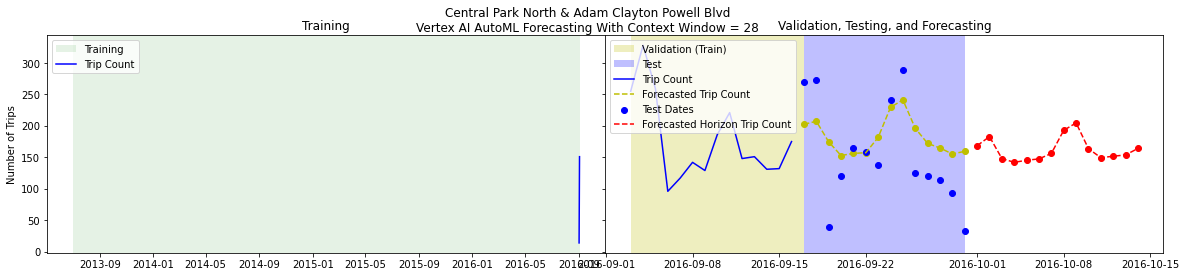

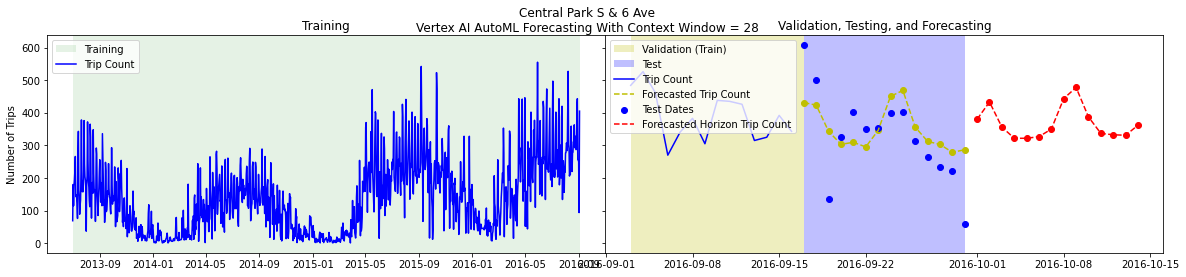

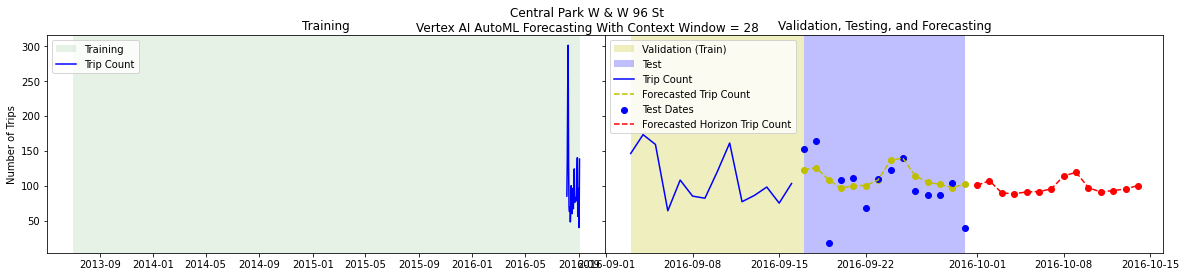

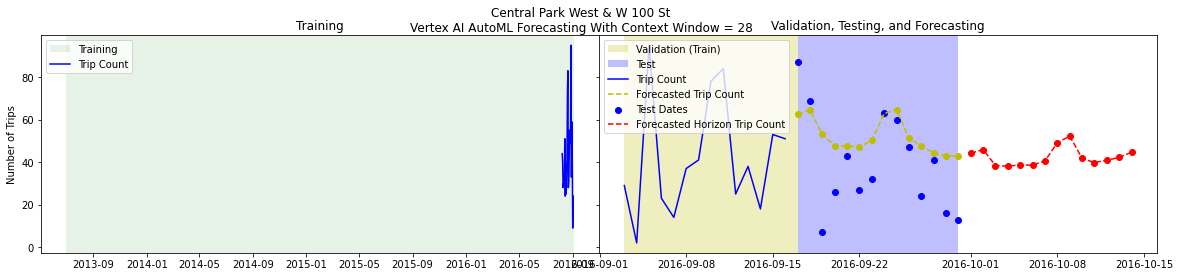

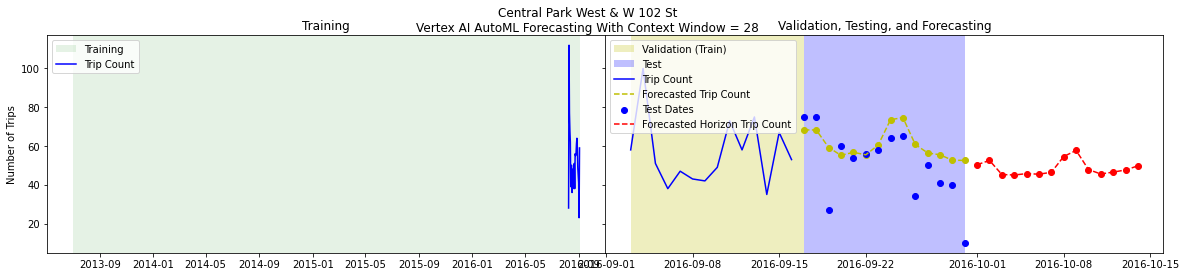

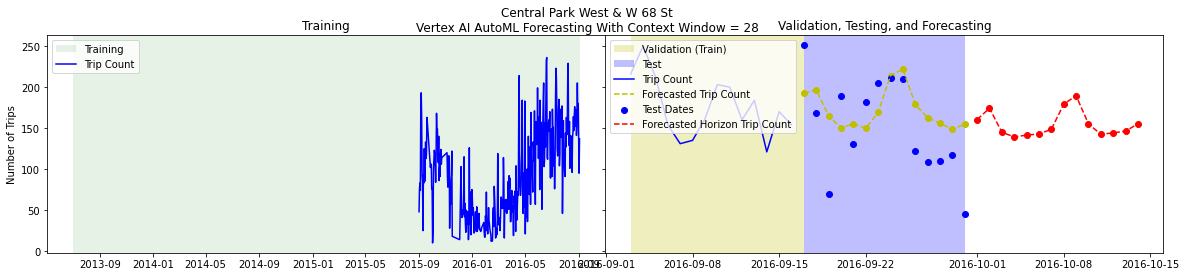

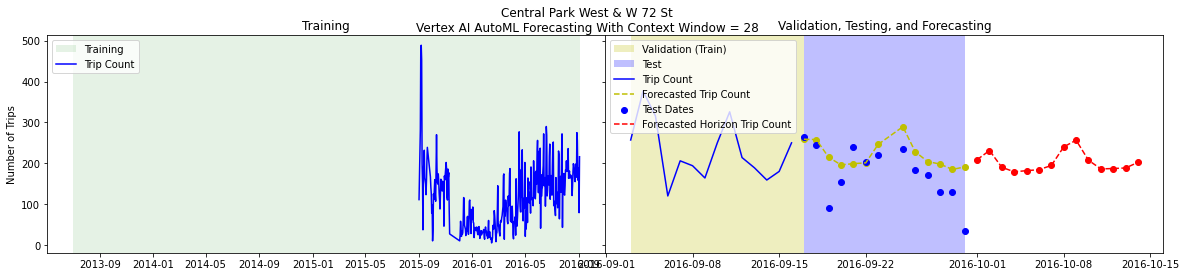

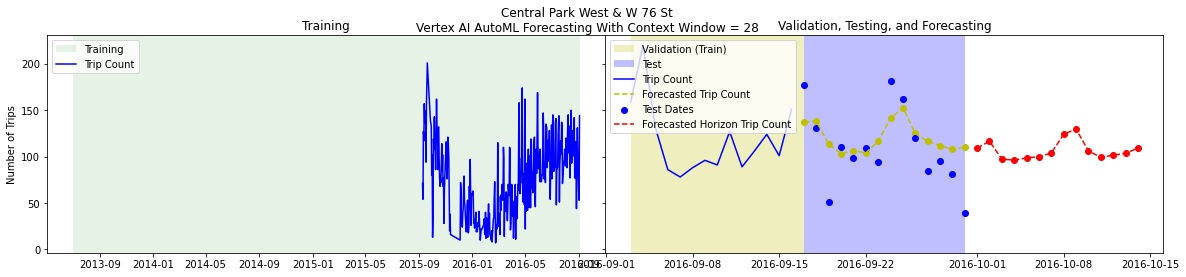

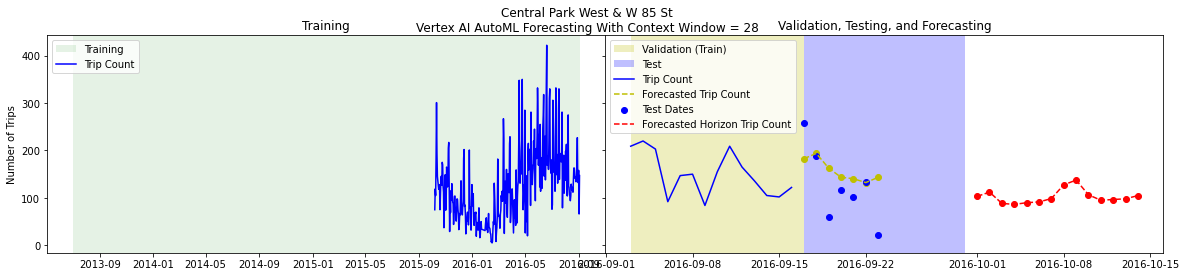

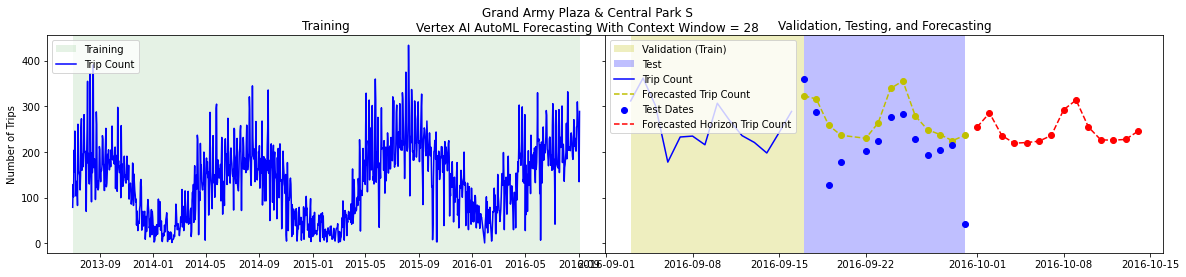

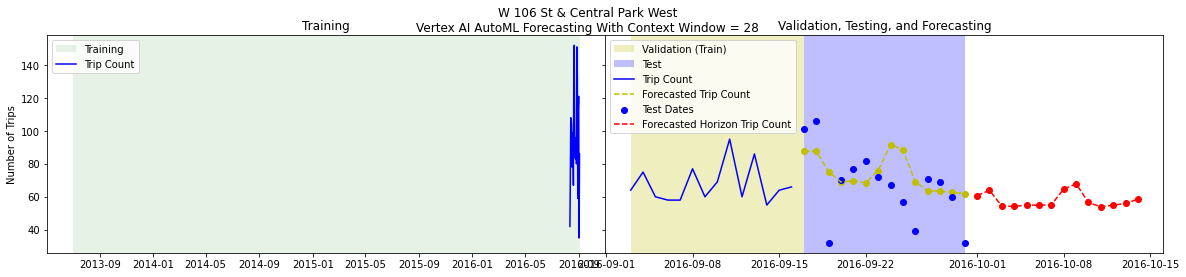

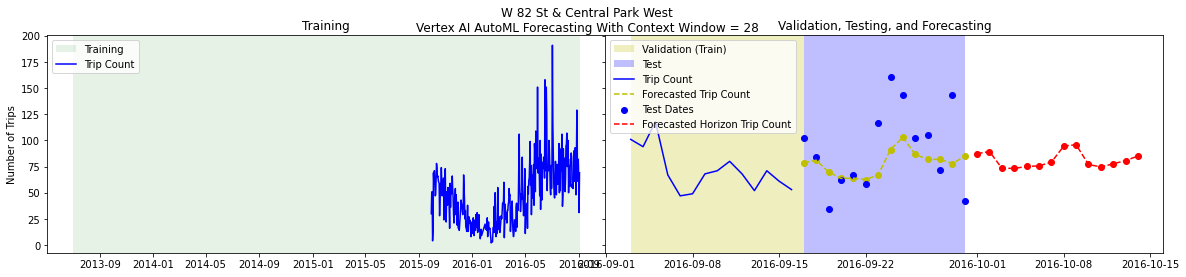

In [69]:
stations = rawSeries['start_station_name'].unique().tolist()
for s, st in enumerate(stations):
    # setup plot area
    fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
    fig.subplots_adjust(wspace=0)
    
    # data
    traindf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TRAIN')]
    valdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'VALIDATE')]
    testdf = rawSeries[(rawSeries['start_station_name'] == st) & (rawSeries['splits'] == 'TEST')]
    fit_testdf = autoML[(autoML['start_station_name'] == st) & (autoML['splits'] == 'TEST')]
    predictdf = predict[(predict['start_station_name'] == st)]
    
    # regions
    axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
    axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
    axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
    
    # lines and dots
    axes[0].plot(traindf['date'], traindf['num_trips'], color = 'b', label = 'Trip Count')
    axes[1].plot(valdf['date'], valdf['num_trips'], color = 'b', label = 'Trip Count')
    #axes[1].plot(testdf['date'], testdf['num_trips'], color = 'b')
    
    axes[1].plot(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y', label = 'Forecasted Trip Count', linestyle='dashed')
    axes[1].scatter(fit_testdf['date'], fit_testdf['predicted_num_trips'], color = 'y')
    
    axes[1].scatter(testdf['date'], testdf['num_trips'], color = 'b', label = 'Test Dates')
    
    axes[1].plot(predictdf['date'], predictdf['predicted_num_trips'], color = 'r', label = 'Forecasted Horizon Trip Count', linestyle='dashed')
    axes[1].scatter(predictdf['date'], predictdf['predicted_num_trips'], color = 'r')
    
    # labels
    axes[0].set_ylabel('Number of Trips')
    axes[0].set_title('Training')
    axes[1].set_title('Validation, Testing, and Forecasting')
    axes[1].legend(loc = 'upper left')
    axes[0].legend(loc = 'upper left')
    plt.suptitle(st + f"\nVertex AI AutoML Forecasting With Context Window = 28")

    # display result
    plt.show()

---
## Remove Resources
see notebook "99 - Cleanup"